In [1]:
import numpy as np
np.set_printoptions(linewidth=np.inf)

Part One

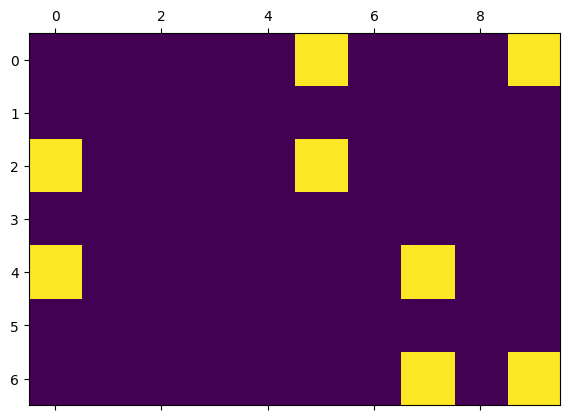

In [2]:
#visualization only for the small example, actual input too large to visualize
import matplotlib.pyplot as plt

with open("example_input09.txt") as f:
    coords = [tuple(map(int,pair.split(','))) for pair in f.readlines()]
coords = coords[:10]
x_min, x_max = min([c[0] for c in coords]), max([c[0] for c in coords])
y_min, y_max = min([c[1] for c in coords]), max([c[1] for c in coords])
grid = np.zeros((x_max - x_min + 1, y_max - y_min + 1), dtype=bool)
for (x,y) in coords:
    grid[x - x_min, y - y_min] = 1
plt.matshow(grid.T);

In [3]:
#taking inspiration from the array manipulation in day 08
coords = np.genfromtxt("input09.txt", delimiter=',', dtype=int)
bc_coords = np.broadcast_to(coords, (coords.shape[0],*coords.shape))
area_matrix = (np.abs(bc_coords - np.transpose(bc_coords, axes=(1,0,2)))+1).prod(axis=2)
np.max(area_matrix)

np.int64(4743645488)

Part Two

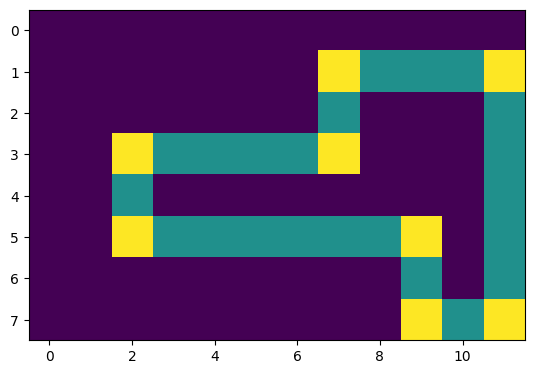

In [38]:
#visualization only for the small example, actual input too large to visualize
import matplotlib.pyplot as plt

with open("example_input09.txt") as f:
    reds = [tuple(map(int,pair.split(','))) for pair in f.readlines()]
greens = set()
for i in range(len(reds)-1):
    x_min, x_max = min(reds[i][0], reds[i+1][0]), max(reds[i][0], reds[i+1][0])
    y_min, y_max = min(reds[i][1], reds[i+1][1]), max(reds[i][1], reds[i+1][1])
    n_tiles = max(x_max - x_min, y_max - y_min) + 1
    greens.update(set(zip(np.linspace(x_min,x_max,n_tiles,dtype=int), 
                     np.linspace(y_min,y_max,n_tiles,dtype=int))))
x_min, x_max = min(reds[-1][0], reds[0][0]), max(reds[-1][0], reds[0][0])
y_min, y_max = min(reds[-1][1], reds[0][1]), max(reds[-1][1], reds[0][1])
n_tiles = max(x_max - x_min, y_max - y_min) + 1
greens.update(set(zip(np.linspace(x_min,x_max,n_tiles,dtype=int), 
                    np.linspace(y_min,y_max,n_tiles,dtype=int))))
reds = set(reds)
greens = set(greens) - reds
# greens

x_min, x_max = min([c[0] for c in reds]), max([c[0] for c in reds])
y_min, y_max = min([c[1] for c in reds]), max([c[1] for c in reds])
grid = np.zeros((x_max + 1, y_max + 1), dtype=int)
for (x,y) in reds:
    grid[x, y] = 2
for (x,y) in greens:
    grid[x, y] = 1
plt.imshow(grid.T);

In [4]:
#taking inspiration from the array manipulation in day 08
coords = np.genfromtxt("input09.txt", delimiter=',', dtype=int)
bc_coords = np.broadcast_to(coords, (coords.shape[0],*coords.shape))
area_matrix = (np.abs(bc_coords - np.transpose(bc_coords, axes=(1,0,2)))+1).prod(axis=2)

We're going to need a bit of an intricate system to detect whether a green straight line crosses other lines of interest.\
The red points are saved as two dictionaries, one indexed by horizontal components, reds_h, the other by vertical components, reds_v. Each red value repeats, such as (i0,j0), (i0,j1), (i1,j1), (i1,j2),...\
Each dictionary value is a tuple, i.e. `{i0: (j0,j1), i1: (j1,j2), ...}` and also `{j1: (i0,i1), j2: (i1,i2),...}`, each tuple sorted ascending.\
This makes it faster to index by row or column to check whether a green line crosses a rectangle

In [5]:
from collections import defaultdict

reds_h, reds_v = defaultdict(set), defaultdict(set)
for p in coords:
    reds_h[int(p[0])].add(int(p[1]))
    reds_v[int(p[1])].add(int(p[0]))
reds_h = {k:tuple(sorted(v)) for k,v in sorted(reds_h.items())}
reds_v = {k:tuple(sorted(v)) for k,v in sorted(reds_v.items())}

#Trying a pre-filter based on red positions to speed things up
range_h_from_red, reds_h_keys = {}, list(reds_h.keys())

for i in range(len(reds_h)):
    i_red, prev_i_red, post_i_red = reds_h_keys[i], reds_h_keys[i-1], reds_h_keys[i+1] if i!=len(reds_h)-1 else -1
    prev_j_reds, post_j_reds = reds_h[prev_i_red] if i else (), reds_h[post_i_red] if i!=len(reds_h)-1 else ()
    for j_red in reds_h[i_red]:
        #unified, simplified range
        upper_left_bound  = min({j for j in prev_j_reds if j < j_red}, default=-1)
        lower_left_bound  = min({j for j in post_j_reds if j < j_red}, default=-1)
        upper_right_bound = max({j for j in prev_j_reds if j > j_red}, default=max(reds_v))
        lower_right_bound = max({j for j in post_j_reds if j > j_red}, default=max(reds_v))

        range_h_from_red[(i_red,j_red)] = (upper_left_bound, upper_right_bound, lower_left_bound, lower_right_bound)

range_v_from_red, reds_v_keys = {}, list(reds_v.keys())

for j in range(len(reds_v)):
    j_red, prev_j_red, post_j_red = reds_v_keys[j], reds_v_keys[j-1], reds_v_keys[j+1] if j!=len(reds_v)-1 else -1
    prev_i_reds, post_i_reds = reds_v[prev_j_red] if j else (), reds_v[post_j_red] if j!=len(reds_v)-1 else ()
    for i_red in reds_v[j_red]:
        #unified, simplified range
        upper_left_bound  = min({i for i in prev_i_reds if i < i_red}, default=-1)
        upper_right_bound = min({i for i in post_i_reds if i < i_red}, default=-1)
        lower_left_bound  = max({i for i in prev_i_reds if i > i_red}, default=max(reds_h))
        lower_right_bound = max({i for i in post_i_reds if i > i_red}, default=max(reds_h))

        range_v_from_red[(i_red,j_red)] = (upper_left_bound, upper_right_bound, lower_left_bound, lower_right_bound)

Idea for change: avoid np.argwhere, check every rectangle (with a quick check on whether rectangle is small)

In [21]:
areas = np.unique(area_matrix)

max_area = (0, () ,())
for pt1 in range(len(coords)):
    (i1, j1) = coords[pt1]
    print("Current max area", int(max_area[0]), end="\r")
    for (i2,j2) in coords[pt1+1:]:
        A = (abs(i2-i1)+1)*(abs(j2-j1)+1)
        if A <= max_area[0]: continue
        # #pre-checking against "closest" red squares
        if i2 < i1:
            if j2 < range_h_from_red[i1,j1][0] or j2 > range_h_from_red[i1,j1][1]: continue
            if j1 < range_h_from_red[i2,j2][2] or j1 > range_h_from_red[i2,j2][3]: continue
        else: #so i1<i2 disregarding width-1, too small area
            if j2 < range_h_from_red[i1,j1][2] or j2 > range_h_from_red[i1,j1][3]: continue
            if j1 < range_h_from_red[i2,j2][0] or j1 > range_h_from_red[i2,j2][1]: continue

        if j2 < j1:
            if i2 < range_v_from_red[i1,j1][0] or i2 > range_v_from_red[i1,j1][2]: continue
            if i1 < range_v_from_red[i2,j2][1] or i1 > range_v_from_red[i2,j2][3]: continue
        else: #so j1<j2 disregarding width-1, too small area
            if i2 < range_v_from_red[i1,j1][1] or i2 > range_v_from_red[i1,j1][3]: continue
            if i1 < range_v_from_red[i2,j2][0] or i1 > range_v_from_red[i2,j2][2]: continue
                                    
        #does any green cross the inside of the rectangle?
        inner_corners = sorted([(ia+np.sign(ib-ia), ja+np.sign(jb-ja)) for ia,ib in [(i1,i2), (i2,i1)] for ja,jb in [(j1,j2),(j2,j1)]])
        #vertical green crosses
        green_in_rectangle=False
        sub_reds_v_middle = {i_tuple for j_red,i_tuple in reds_v.items() if inner_corners[0][1]<j_red<inner_corners[1][1]}
        for i_tuple in sub_reds_v_middle:
            if i_tuple[0]<inner_corners[0][0]<i_tuple[1]:# or i_tuple[0]<inner_corners[2][0]<i_tuple[1]: #with later check it can only cross both sides
                green_in_rectangle=True
                break
        if green_in_rectangle: continue
        #horizontal green crosses
        green_in_rectangle=False
        sub_reds_h_middle = {j_tuple for i_red,j_tuple in reds_h.items() if inner_corners[0][0]<i_red<inner_corners[2][0]}
        for j_tuple in sub_reds_h_middle:
            if j_tuple[0]<=inner_corners[0][1]<=j_tuple[1]:# or j_tuple[0]<=inner_corners[1][1]<=j_tuple[1]: #with later check it can only cross both j1,j2
                green_in_rectangle=True
                break
        if green_in_rectangle: continue

        #checking reds inside the rectangle
        red_inside = False
        for i in {i for j_red,i_tuple in reds_v.items() if min(j1,j2)<j_red<max(j1,j2) for i in i_tuple}:
            if min(i1,i2)<i<max(i1,i2):
                red_inside=True
                break
        if red_inside: continue
        # red_inside = False
        # for j in {j for i_red,j_tuple in reds_h.items() if min(i1,i2)<i_red<max(i1,i2) for j in j_tuple}:
        #     if min(j1,j2)<j<max(j1,j2):
        #         red_inside=True
        #         break
        # if red_inside: continue

        ###The next step uses the fact that there are no consecutive-row red squares
        ### if min(sorted(reds_h.keys())[i]-sorted(reds_h.keys())[i-1] for i in range(1,len(reds_h)))>1: pass
        ### else: raise ValueError("Reds in adjacent rows")

        #how many greens cross the path from border to first_in?       
        first_in = inner_corners[0] #(i1+np.sign(i2-i1), j1+np.sign(j2-j1))
        sub_reds_v_left = {i_tuple for j_red,i_tuple in reds_v.items() if j_red<first_in[1]}
        green_crosses = 0
        for i_tuple in sub_reds_v_left:
            if i_tuple[0]<first_in[0]<i_tuple[1]: green_crosses+=1
        if green_crosses%2==0: continue
        max_area = max((A, (i1,j1), (i2,j2)), max_area)

print(f"Max area: {int(max_area[0])}, " + 
      f"coordinates {tuple(int(i) for i in max_area[1])}, {tuple(int(i) for i in max_area[2])}")

Max area: 1529011204, coordinates (5106, 67466), (94699, 50401)


About 5s with all my pre-checks

Previous part-two method. Using np.argwhere is *SLOW*. This makes the code take 20x longer (around a minute)

In [ ]:
areas = np.unique(area_matrix)

leave=False
for A in areas[::-1]:
    if A%10000==5488: print("Trying area", A, end="\r")
    for pt1, pt2 in np.argwhere(area_matrix==A):
        if pt1>=pt2: continue
        (i1, j1), (i2,j2) = coords[pt1], coords[pt2]

        #pre-checking against "closest" red squares
        if i2 < i1:
            if j2 < range_h_from_red[i1,j1][0] or j2 > range_h_from_red[i1,j1][1]: continue
            if j1 < range_h_from_red[i2,j2][2] or j1 > range_h_from_red[i2,j2][3]: continue
        else: #so i1<i2 disregarding width-1, too small area
            if j2 < range_h_from_red[i1,j1][2] or j2 > range_h_from_red[i1,j1][3]: continue
            if j1 < range_h_from_red[i2,j2][0] or j1 > range_h_from_red[i2,j2][1]: continue

        if j2 < j1:
            if i2 < range_v_from_red[i1,j1][0] or i2 > range_v_from_red[i1,j1][2]: continue
            if i1 < range_v_from_red[i2,j2][1] or i1 > range_v_from_red[i2,j2][3]: continue
        else: #so j1<j2 disregarding width-1, too small area
            if i2 < range_v_from_red[i1,j1][1] or i2 > range_v_from_red[i1,j1][3]: continue
            if i1 < range_v_from_red[i2,j2][0] or i1 > range_v_from_red[i2,j2][2]: continue
                                    
        #does any green cross the inside of the rectangle?
        inner_corners = sorted([(ia+np.sign(ib-ia), ja+np.sign(jb-ja)) for ia,ib in [(i1,i2), (i2,i1)] for ja,jb in [(j1,j2),(j2,j1)]])
        #vertical green crosses
        green_in_rectangle=False
        sub_reds_v_middle = {i_tuple for j_red,i_tuple in reds_v.items() if inner_corners[0][1]<j_red<inner_corners[1][1]}
        for i_tuple in sub_reds_v_middle:
            if i_tuple[0]<inner_corners[0][0]<i_tuple[1]:# or i_tuple[0]<inner_corners[2][0]<i_tuple[1]: #with later check it can only cross both sides
                green_in_rectangle=True
                break
        if green_in_rectangle: continue
        #horizontal green crosses
        green_in_rectangle=False
        sub_reds_h_middle = {j_tuple for i_red,j_tuple in reds_h.items() if inner_corners[0][0]<i_red<inner_corners[2][0]}
        for j_tuple in sub_reds_h_middle:
            if j_tuple[0]<=inner_corners[0][1]<=j_tuple[1]:# or j_tuple[0]<=inner_corners[1][1]<=j_tuple[1]: #with later check it can only cross both j1,j2
                green_in_rectangle=True
                break
        if green_in_rectangle: continue

        #checking reds inside the rectangle
        red_inside = False
        for i in {i for j_red,i_tuple in reds_v.items() if min(j1,j2)<j_red<max(j1,j2) for i in i_tuple}:
            if min(i1,i2)<i<max(i1,i2):
                red_inside=True
                break
        if red_inside: continue
        # red_inside = False
        # for j in {j for i_red,j_tuple in reds_h.items() if min(i1,i2)<i_red<max(i1,i2) for j in j_tuple}:
        #     if min(j1,j2)<j<max(j1,j2):
        #         red_inside=True
        #         break
        # if red_inside: continue

        ###The next step uses the fact that there are no consecutive-row red squares
        ### if min(sorted(reds_h.keys())[i]-sorted(reds_h.keys())[i-1] for i in range(1,len(reds_h)))>1: pass
        ### else: raise ValueError("Reds in adjacent rows")

        #how many greens cross the path from border to first_in?       
        first_in = inner_corners[0] #(i1+np.sign(i2-i1), j1+np.sign(j2-j1))
        sub_reds_v_left = {i_tuple for j_red,i_tuple in reds_v.items() if j_red<first_in[1]}
        green_crosses = 0
        for i_tuple in sub_reds_v_left:
            if i_tuple[0]<first_in[0]<i_tuple[1]: green_crosses+=1
        if green_crosses%2==0: continue

        print("Max area", A, i1,j1, i2,j2)
        leave=True
        break
    if leave: break

Max area 1529011204 5106 67466 94699 50401
